## Plan

### Data visualization
    - fraud vs non fraud count (plot)
    - frauds describe
    - separate numerical and categorical data
    - encode categorical data
    - view pca 

### Data preprocessing
    - remove/fill null values
    - perform memory reduction
    - what to do with categorical data ?
    - how to handle imbalanced data
        - over sampling or under sampling

### Train and Predict

### performance measure
    - precision, recall, f1 score
    - ROC curves

## Utility methods

In [181]:
def reduce_mem_usage(df):
    numv = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem,
                                                                          100 * (start_mem - end_mem) / start_mem))
    return df

def fill_na(df, int_filler=0, string_filler=""):
    for column in df.columns:
        col_type = str(df[column].dtype)
        if "int" or "float" in col_type:
            df[column].fillna(int_filler, inplace=True)

        if "object" in col_type:
            df[column].fillna(string_filler, inplace=True)
    return df

def under_sample(features_df, target_df, sampling_strategy):
    rus = RandomUnderSampler(random_state=111, sampling_strategy=sampling_strategy)
    filtered_features_df, filtered_target_df = rus.fit_resample(features_df, target_df)
    return pd.DataFrame(data=filtered_features_df, columns=features_df.columns.values), \
           pd.DataFrame(data=filtered_target_df, columns=target_df.columns.values)


def change_data_type(target_df, source_df):
    for col in target_df.columns:
        target_df[col] = target_df[col].astype(source_df[col].dtype)
    return target_df

def perform_pca(df, num_of_components):
    pca = PCA(n_components=num_of_components)
    principal_components = pca.fit_transform(df)
    print("explained_variance_ratio : " + str(pca.explained_variance_ratio_))
    return pd.DataFrame(data=principal_components, columns=['pc_' + str(x) for x in range(num_of_components)])

def plot_confusion_matrix(confusion_matrix, class_names, fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Parameters
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure()
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, \
                                 ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, \
                                 ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Data visualization and preprocessing

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
sns.set()

### Merge transaction and identity data

In [183]:
train_transaction_df = pd.read_csv("data/train_transaction.csv")
train_identity_df = pd.read_csv("data/train_identity.csv")
train_df = pd.merge(train_transaction_df, train_identity_df, on='TransactionID', how='left')

### Fraud vs Non Fraud
    
    - it shows that data is imbalanced

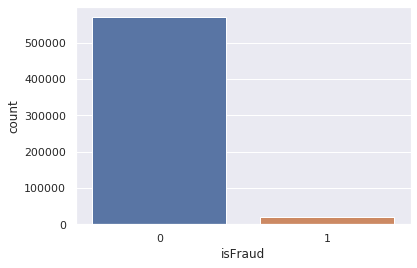

In [184]:
sns.countplot(x='isFraud', data=train_df)

### Reduce memory usage

In [185]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 670.48 Mb (66.1% reduction)


### Fill nan

In [186]:
train_df = fill_na(train_df, int_filler=-9999)

### Segregating feature and target data

In [187]:
target_column = 'isFraud'
target_df = train_df[[target_column]]
feature_columns = set(train_df.columns) - {target_column}
features_df = train_df[feature_columns]

### Undersampling features and target

In [188]:
sampled_features_df, target_df = under_sample(features_df, target_df, sampling_strategy = 1)
sampled_features_df = change_data_type(sampled_features_df, features_df)

### Separating numerical and categorical data

In [189]:
numerical_features_df = sampled_features_df._get_numeric_data()
categorical_features_df = sampled_features_df[feature_columns - set(numerical_features_df.columns)]

In [190]:
print(len(target_df[target_df['isFraud'] == 1]))
print(len(target_df[target_df['isFraud'] == 0]))

20663
20663


### Encoding categorical data         

In [191]:
encoded_categorical_features_df = pd.get_dummies(categorical_features_df)

### Merging all features

In [192]:
features_df = pd.concat((numerical_features_df, encoded_categorical_features_df), axis=1)

## Training and prediction

In [193]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2)

In [195]:
lr = LogisticRegression(random_state=111, solver='lbfgs',multi_class='ovr', max_iter = 250, n_jobs=-1).fit(x_train, y_train.values.ravel())

In [196]:
y_pred = lr.predict(x_test)

## Measuring performace

In [197]:
print("Recall score : " + str(recall_score(y_test, y_pred)))
print("Accuracy score : " + str(accuracy_score(y_test, y_pred)))

Recall score : 0.5298525501571187
Accuracy score : 0.684974594725381


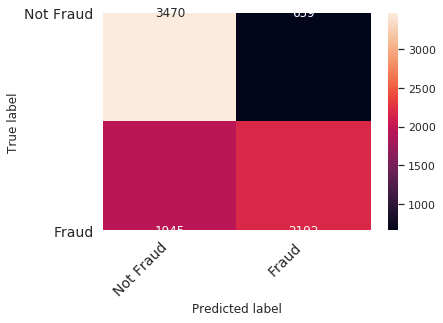

In [198]:
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(confusion_mat, ['Not Fraud', 'Fraud'])

## Next steps
    - 